In [27]:
import torch
import torch.nn as nn
from stabnode.node import MLP
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from data.budworm import simulate_trials
from sklearn.preprocessing import MinMaxScaler

In [13]:
class GeluSigmoidMLPfeaturized(nn.Module):
    def __init__(
        self,
        dims,
        activation = torch.nn.SiLU(),
        lower_bound=0,
        upper_bound=1,
        freq_sample_step = 5
    ):
        super().__init__()

        self.dims = dims
        self.activation = activation
        self.network = MLP(self.dims, activation = self.activation)

        self.freq_sample_step = freq_sample_step
        self.featurization_dim = dims[0] - 2
        self.freqs = torch.arange(0,self.featurization_dim*self.freq_sample_step,self.freq_sample_step)
        

        self.args = {
            "lower_bound": lower_bound,
            "upper_bound": upper_bound
        }

    def forward(self,x,u):
        a = self.args['lower_bound']
        b = self.args['upper_bound']
        x_feats = [x]
        for fq in self.freqs:
            x_feats.append(torch.cos(fq**2*3.14*(x- a)/(b-a)))
        xf = torch.cat(x_feats,dim=-1)
        xu = torch.cat([xf,u],dim=-1)


        return a + (b-a)*torch.sigmoid(self.network(xu))

In [14]:
g = GeluSigmoidMLPfeaturized(dims = [6,10,10,1], activation = torch.nn.SiLU(), lower_bound = 0, upper_bound = 1, freq_sample_step = 1 )

In [15]:
freqs = g.freqs
a = g.args["lower_bound"]
b = g.args["upper_bound"]

In [16]:
a,b

(0, 1)

In [17]:
# x = np.linspace(0,1,101)

## Generate more interesting data
k = 8.5

xs = []
ts = []
x0s = np.linspace(0.1,10,51)
for x0 in x0s:
    budworm_trial =simulate_trials([k],x0, dt=0.1,r=0.56,eps=1e-3,buffer=1e-1,t_max=400,n_points=501, show_progress=False)
    xs.append(budworm_trial.x_vals[0])
    ts.append(budworm_trial.t_vals[0])

In [18]:
scaler = MinMaxScaler()
scaler.fit(np.concatenate(xs).reshape(-1,1))

xs_scaled = [scaler.transform(xi.reshape(-1,1)).reshape(-1) for xi in xs]

In [19]:
x = xs_scaled[-1]

In [20]:
freqs

tensor([0, 1, 2, 3])

In [21]:
x_feats = [x]
a,b=0,1
for fq in freqs:
    x_feats.append(np.cos(fq**2*3.14*(x- a)/(b-a)))

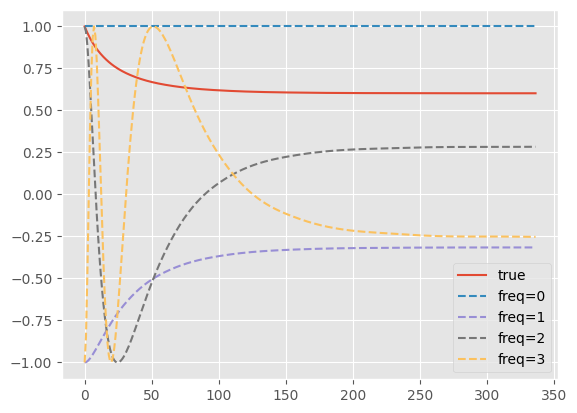

In [22]:

for idx, xi in enumerate(x_feats):
    if idx ==0:
        plt.plot(xi,label='true')
    else:
        plt.plot(xi, label=f"freq={freqs[idx-1]}",linestyle='--')
    
plt.legend()
plt.show()

# True $\tilde g$

In [28]:
from data.budworm import g_true, f_true

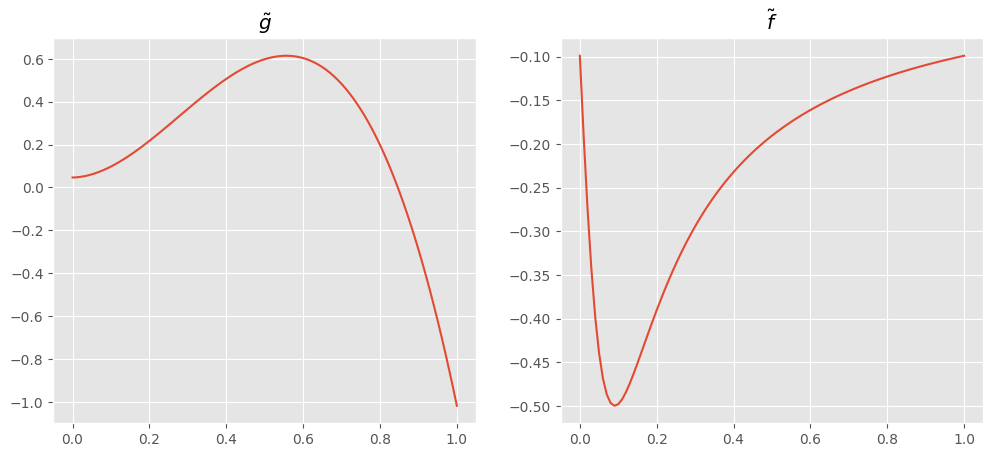

In [29]:
x_lin = np.linspace(0,1,101)
x_lin_unscaled = scaler.inverse_transform(x_lin.reshape(-1,1)).reshape(-1)

f_true_arr = f_true(x_lin_unscaled)
g_true_arr = scaler.transform(g_true(x_lin_unscaled, k, r=0.56).reshape(-1,1)).reshape(-1)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(x_lin, g_true_arr)
ax1.set_title(r"$\tilde{g}$")
ax2.plot(x_lin, f_true_arr)
ax2.set_title(r"$\tilde{f}$")
plt.show()

$$
\dot x = rx (1-x/k) - \frac{x^2}{1+x^2}
$$

$$
g = \frac{r}{k}(1+x^2)(k-x) \quad \text{and} \quad f = -\frac{x}{1+x^2}
$$

$$
g(x,k)=-\frac{r}{k}x^3 + rx^2 -\frac{r}{k}x +r 
$$

$$
\begin{align*}
f &= -(x)(1+x^2)^{-1}\\
f' &= -\frac{1}{1+x^2} + \frac{2x^2}{(1+x^2)^2}\\
f'' &= \frac{2x}{(1+x^2)^2} + \frac{4x}{(1+x^2)^2} - \frac{16x^2}{(1+x^2)^3}
\end{align*}
$$

$$
\mathcal{P}(f) = f(x_0) + f'(x_0)(x-x_0) + \frac{1}{2}f''(x_0)(x-x_0)^2 + \mathcal{O}(x-x_0)^3
$$

In [ ]:
import numpy as np

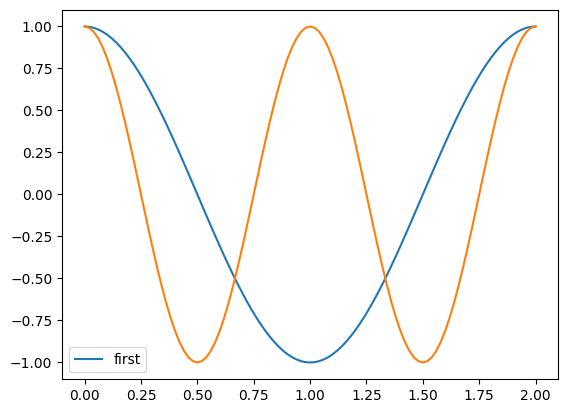

In [28]:
x = np.linspace(0,2,101)
plt.plot(x,np.cos(np.pi*x),label="first")
plt.plot(x,np.cos(2*np.pi*x))
plt.legend()